In [18]:
%matplotlib inline

import numpy as np
import os
import json
import pandas as pd
from matplotlib import pyplot as plt

In [19]:
nproc = range(1, 11)

In [20]:
def speedup(t_serial, t):
    return t_serial/t

In [21]:
def read_profiling_files(profile_dir_path="."):
    profiling_data = pd.DataFrame()

    json_filenames = [file for file in os.listdir(profile_dir_path) if file.endswith("_profiling.json")]

    for json_filename in json_filenames:
        with open(os.path.join(profile_dir_path, json_filename)) as json_file:
            profiling_data = profiling_data.append(json.load(json_file), ignore_index=True)

    profiling_data = profiling_data.sort_values(by=["n_processes"])

    return profiling_data

profiling_data = read_profiling_files()
print(profiling_data)

        dt n_cuda_devices n_processes  n_time_steps      nx      ny  \
0  0.00001              2           1       20002.0  4096.0  4096.0   
1  0.00001              2           2       20002.0  4096.0  2048.0   
5  0.00001              2           3       20002.0  4096.0  1365.0   
4  0.00001              2           4       20002.0  4096.0  1024.0   
7  0.00001              2           5       20002.0  4096.0   819.0   
3  0.00001              2           6       20002.0  4096.0   683.0   
2  0.00001              2           7       20002.0  4096.0   585.0   
6  0.00001              2           8       20002.0  4096.0   512.0   

  slurm_job_id    t_init  t_nc_write  t_sim_init  t_sim_mpi_init      t_step  \
0               0.755573    3.819266   21.847542        0.000650  164.309420   
1               0.640923    1.762661   11.810046        0.000821   94.098560   
5               0.507208    1.252253    8.936866        0.000799  121.531043   
4               0.562472    0.697483    

## Weak scaling

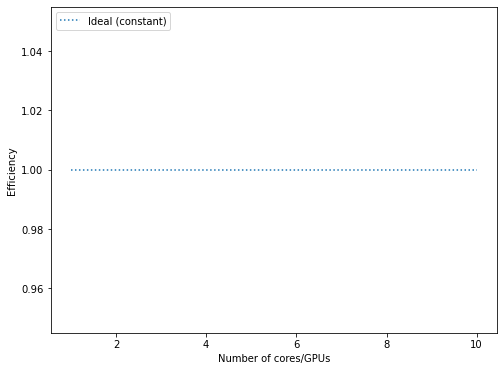

In [9]:
fig, ax = plt.subplots(figsize=(8,6))

#ax.plot(nproc, speedup, label="Actual")

ax.plot(nproc, np.ones(len(nproc)), label="Ideal (constant)", linestyle="dotted")

ax.set_xlabel("Number of cores/GPUs")
ax.set_ylabel("Efficiency")
ax.legend(loc="upper left")
fig.show()

## Strong scaling

In [10]:
def amdahls_speedup(parallel_share, nproc):
    serial_share = 1.0 - parallel_share
    return [1.0 / (serial_share + parallel_share / float(n)) for n in nproc]

In [11]:
def gustafsons_speedup(parallel_share, nproc):
    serial_share = 1.0 - parallel_share
    return [serial_share + parallel_share * float(n) for n in nproc]

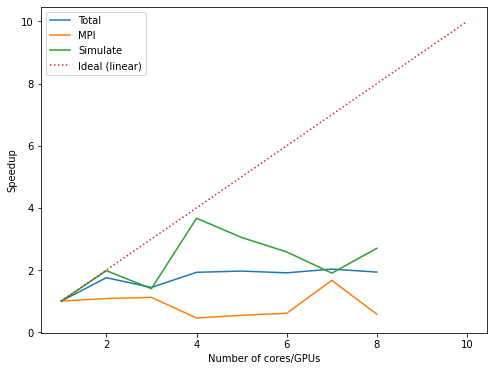

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_total"][0], profiling_data["t_total"]), label="Total")

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_step_mpi_halo_exchange"][0], profiling_data["t_step_mpi_halo_exchange"]), label="MPI")

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_step_mpi"][0], profiling_data["t_step_mpi"]), label="Simulate")

#ax.plot(nproc, amdahls_speedup(0.9, nproc), label="Amdahls 90%", linestyle="dashed")
#ax.plot(nproc, amdahls_speedup(0.5, nproc), label="Amdahls 50%", linestyle="dashed")
#ax.plot(nproc, amdahls_speedup(0.1, nproc), label="Amdahls 10%", linestyle="dashed")

#ax.plot(nproc, gustafsons_speedup(0.9, nproc), label="Gustafsons 90%")
#ax.plot(nproc, gustafsons_speedup(0.5, nproc), label="Gustafsons 50%")
#ax.plot(nproc, gustafsons_speedup(0.1, nproc), label="Gustafsons 10%")

ax.plot(nproc, nproc, label="Ideal (linear)", linestyle="dotted")

ax.set_xlabel("Number of cores/GPUs")
ax.set_ylabel("Speedup")
ax.legend(loc="upper left")
fig.show()

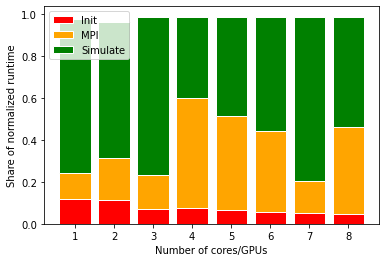

In [13]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])/profiling_data["t_total"]
share_mpi = profiling_data["t_step_mpi_halo_exchange"]/profiling_data["t_total"]
share_simulate = profiling_data["t_step_mpi"]/profiling_data["t_total"]

plt.bar(profiling_data["n_processes"], 
    share_init, color='red', edgecolor='white', width=bar_width, label="Init")

plt.bar(profiling_data["n_processes"], 
    share_mpi, bottom=share_init, color='orange', edgecolor='white', width=bar_width, label="MPI")

plt.bar(profiling_data["n_processes"], 
    share_simulate, bottom=share_init+share_mpi , color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Share of normalized runtime")
plt.legend(loc="upper left")

plt.show()

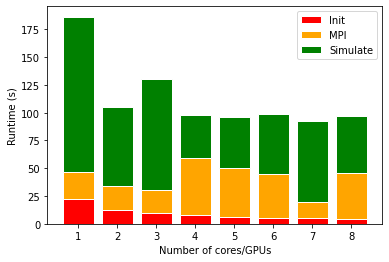

In [16]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])
share_mpi = profiling_data["t_step_mpi_halo_exchange"]
share_simulate = profiling_data["t_step_mpi"]

plt.bar(profiling_data["n_processes"], 
    share_init, color='red', edgecolor='white', width=bar_width, label="Init")

plt.bar(profiling_data["n_processes"], 
    share_mpi, bottom=share_init, color='orange', edgecolor='white', width=bar_width, label="MPI")

plt.bar(profiling_data["n_processes"], 
    share_simulate, bottom=share_init+share_mpi , color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Runtime (s)")
plt.legend(loc="upper right")

plt.show()

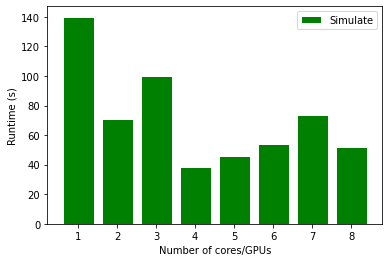

In [17]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])
share_mpi = profiling_data["t_step_mpi_halo_exchange"]
share_simulate = profiling_data["t_step_mpi"]


plt.bar(profiling_data["n_processes"], 
    share_simulate, color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Runtime (s)")
plt.legend(loc="upper right")

plt.show()

In [ ]:
1. Detaljert
2. Asynkron: up/download MPI/GPU-comm
3. Benchmark igjen på OSloMet
4. Sjekke reservasjon på Saga og DGX-2
5. Sjekke resultater for 3 subdomener